In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import glob
import os

In [2]:
def read_csv(directory):
    path = directory
    all_files = glob.glob(os.path.join(path, '*.csv'))

    l = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        l.append(df)

    df = pd.concat(l, axis=0, ignore_index=True)
    
    return df

In [3]:
climate_df = read_csv('Climate_data')
carbon_df = read_csv('CO2_data')

In [4]:
climate_df['DATE'] = pd.to_datetime(climate_df['DATE'])

In [5]:
columns = {'DATE':'Date',
           'ADPT':'Average Dew Point Temperature', 
           'AWND':'Average Wind Speed',
           'PRCP':'Total Monthly Precipitation',
           'PSUN':'Monthly Average of the daily percents of possible sunshine',
           'TAVG':'Average Monthly Temperature',
           'TMAX':'Monthly Maximum Temperature',
           'TMIN':'Monthly Minimum Temperature',
           'RHAV':'Relative Humidity'}

climate_df = climate_df.rename(columns=columns)

In [6]:
columns = {'DATE':'Date',
           'ADPT':'Average Dew Point Temperature', 
           'AWND':'Average Wind Speed',
           'PRCP':'Total Monthly Precipitation',
           'PSUN':'Monthly Average of the daily percents of possible sunshine',
           'TAVG':'Average Monthly Temperature',
           'TMAX':'Monthly Maximum Temperature',
           'TMIN':'Monthly Minimum Temperature',
           'RHAV':'Relative Humidity'}

climate_df = climate_df.rename(columns=columns)

In [7]:
cols = ['Date',
        'Average Dew Point Temperature',
        'Average Wind Speed',
        'Total Monthly Precipitation',
        'Monthly Average of the daily percents of possible sunshine',
        'Average Monthly Temperature',
        'Monthly Maximum Temperature',
        'Monthly Minimum Temperature',
        'Relative Humidity']

def create_df(name, column_names, dataframe, site='NAME'):
    df = dataframe[dataframe[site] == name]
    df = df[column_names]
    return df.set_index('Date')

bou = create_df('BOULDER, CO US', cols, climate_df)
hil = create_df('HILO INTERNATIONAL AIRPORT 87, HI US', cols, climate_df)
hoh = create_df('HOHENPEISSENBERG, GM', cols, climate_df)
cap = create_df('CAPE FLORIDA, FL US', cols, climate_df)
los = create_df('LOS ANGELES DOWNTOWN USC, CA US', cols, climate_df)
san = create_df('SAN FRANCISCO DOWNTOWN, CA US', cols, climate_df)
ice = create_df('VESTMANNAEYJAR, IC', cols, climate_df)
tem = create_df('TEMPLE DRAUGHTON MIL, TX US', cols, climate_df)

In [8]:
carbon_df[['year', 'month']] = carbon_df[['year', 'month']].astype(str)
carbon_df['Date'] = carbon_df[['year', 'month']].agg(''.join, axis=1)
carbon_df['Date'] = carbon_df['Date'].astype(int)
carbon_df['Date'] = pd.to_datetime(carbon_df['Date'], format='%Y%m')

In [9]:
cols_co2 = ['Date', 'site_code', 'latitude', 'longitude', 'value',]

bou_co2 = create_df('BAO', cols_co2, carbon_df, site='site_code')
hil_co2 = create_df('MLO', cols_co2, carbon_df, site='site_code')
hoh_co2 = create_df('HPB', cols_co2, carbon_df, site='site_code')
cap_co2 = create_df('KEY', cols_co2, carbon_df, site='site_code')
los_co2 = create_df('MWO', cols_co2, carbon_df, site='site_code')
san_co2 = create_df('STR', cols_co2, carbon_df, site='site_code')
ice_co2 = create_df('ICE', cols_co2, carbon_df, site='site_code')
tem_co2 = create_df('WKT', cols_co2, carbon_df, site='site_code')

In [10]:
def plot(y_value, df, x_value='Date', bin_num=100):    
    median = df[y_value].median()
    
    sns.set(rc={'figure.figsize':(10,10)})
    sns.set_style('white')
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 10), dpi=100)
    sns.scatterplot(data=df, x=x_value, y=y_value, ax=axs[0])
    sns.histplot(data=df[y_value], kde=True, bins=bin_num, ax=axs[1])
    axs[1].axvline(median, color='r')
    plt.tight_layout()

In [11]:
def outlier(df, column='value'):
    
    median = df[column].median()
    df.loc[df['value'] < 0, 'value'] = median
    
    std = df[column].std()
    outliers = (df[column] - median).abs() > 3*std

    df.loc[outliers] = np.nan
    df[column].fillna(median, inplace=True)
    
    return df

In [12]:
bou_co2 = outlier(bou_co2)
hil_co2 = outlier(hil_co2)
hoh_co2 = outlier(hoh_co2)
cap_co2 = outlier(cap_co2)
los_co2 = outlier(los_co2)
san_co2 = outlier(san_co2)
ice_co2 = outlier(ice_co2)
tem_co2 = outlier(tem_co2)

In [13]:
def monthly_averages(climate_df, co2_df):
    grouper = pd.Grouper(level='Date', freq='M')
    df = climate_df.groupby(grouper).mean()
    df1 = co2_df.groupby(grouper).mean()
    return df.join(df1, lsuffix='_left', rsuffix='_right', how='outer')

In [14]:
bou_monthly = monthly_averages(bou, bou_co2)
hil_monthly = monthly_averages(hil, hil_co2)
hoh_monthly = monthly_averages(hoh, hoh_co2)
cap_monthly = monthly_averages(cap, cap_co2)
los_monthly = monthly_averages(los, los_co2)
san_monthly = monthly_averages(san, san_co2)
ice_monthly = monthly_averages(ice, ice_co2)
tem_monthly = monthly_averages(tem, tem_co2)

In [15]:
bou_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1562 entries, 1893-10-31 to 2023-11-30
Freq: M
Data columns (total 11 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Average Dew Point Temperature                               0 non-null      float64
 1   Average Wind Speed                                          0 non-null      float64
 2   Total Monthly Precipitation                                 1444 non-null   float64
 3   Monthly Average of the daily percents of possible sunshine  0 non-null      float64
 4   Average Monthly Temperature                                 1497 non-null   float64
 5   Monthly Maximum Temperature                                 1498 non-null   float64
 6   Monthly Minimum Temperature                                 1504 non-null   float64
 7   Relative Humidity                                           0

In [16]:
list_df = [bou_monthly, hil_monthly, hoh_monthly, cap_monthly, los_monthly, san_monthly, ice_monthly, tem_monthly]

for df in list_df:
    for col in df.columns:
        if df[col].isna().sum() < 0.25*len(df[col]):
            median = df[col].median()
            df[col].fillna(median, inplace=True)

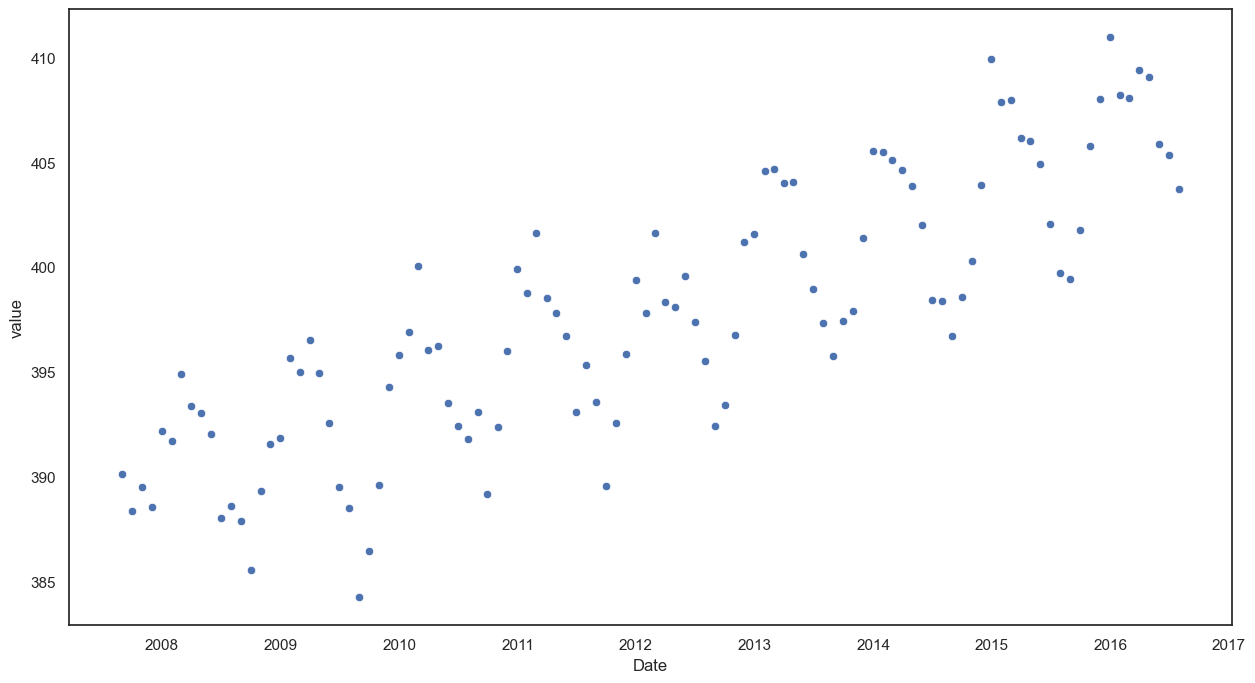

In [17]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('white')

sns.scatterplot(data=bou_monthly,
                x=bou_monthly.index,
                y='value');

In [18]:
bou_monthly.dropna(subset=['value'],how='any',inplace=True)
bou_monthly['value'].isnull().sum()

0

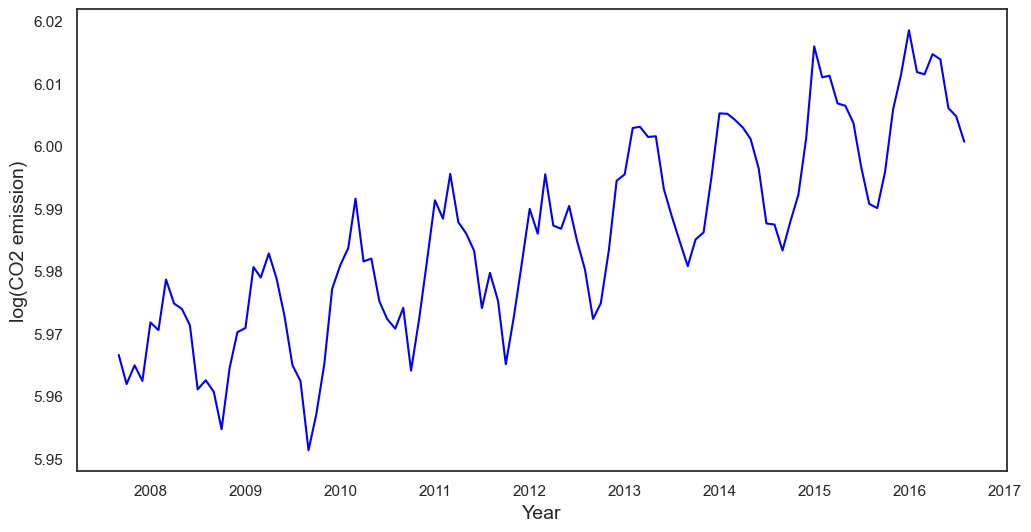

In [19]:
data = pd.Series(np.log(bou_monthly['value']), index=bou_monthly.index)
fig = plt.figure(figsize=(12,6))
plt.plot(data, color='blue')
plt.xlabel('Year', fontsize=14)
plt.ylabel('log(CO2 emission)', fontsize=14)
plt.show()

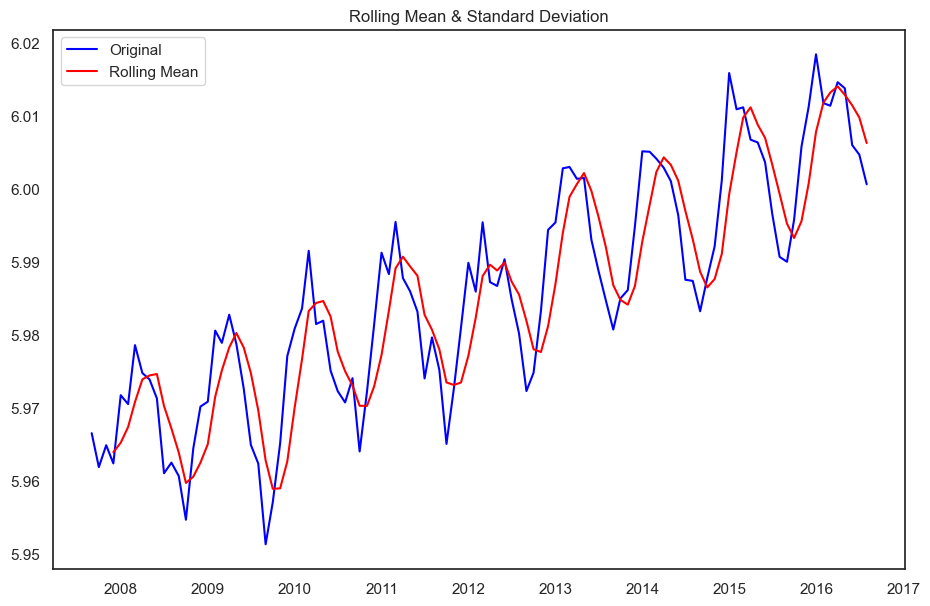

In [20]:
roll_mean = data.rolling(window=4).mean()
fig = plt.figure(figsize=(11,7))
plt.plot(data, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

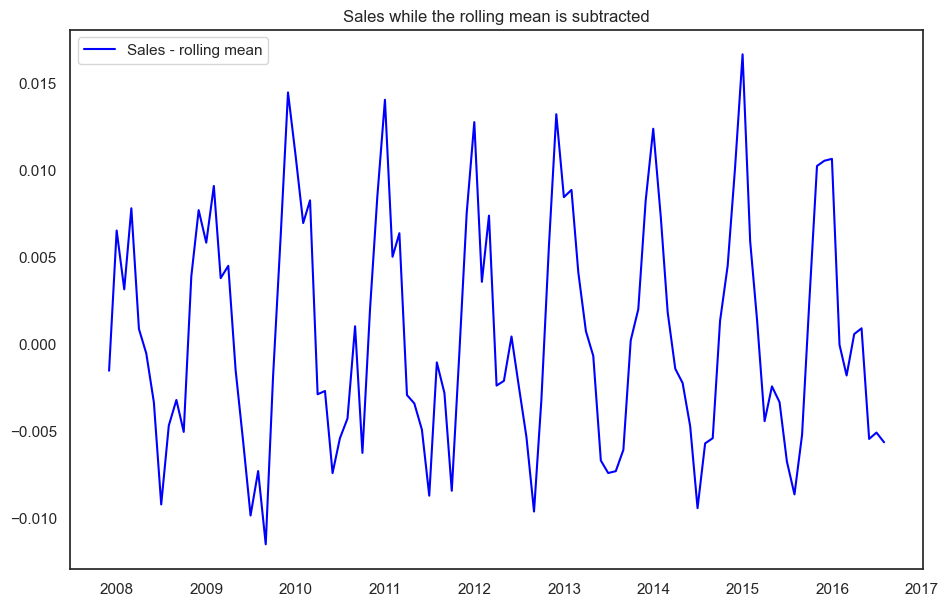

In [21]:
data_minus_roll_mean = data - roll_mean
data_minus_roll_mean.dropna(inplace=True)

fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_roll_mean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

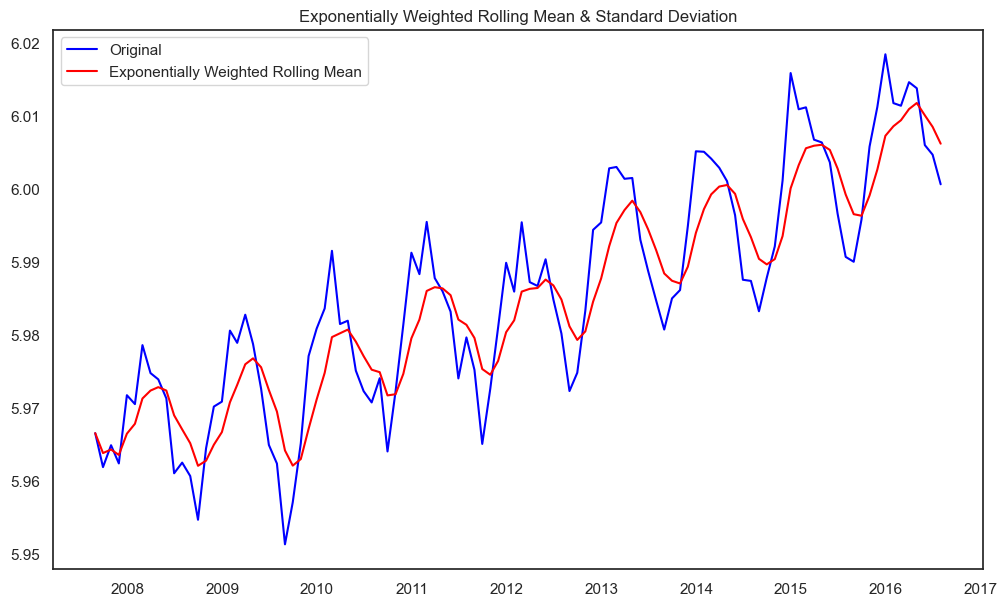

In [22]:
exp_roll_mean = data.ewm(halflife=2).mean()

fig = plt.figure(figsize=(12,7))
orig = plt.plot(data, color='blue',label='Original')
mean = plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show(block=False)

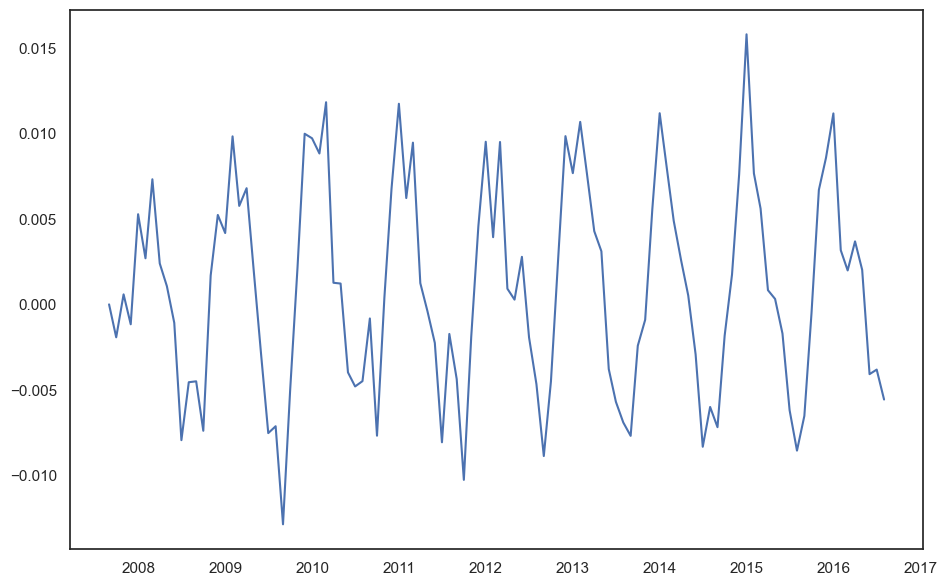

In [23]:
data_minus_exp_roll_mean = data - exp_roll_mean

fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean)

plt.show(block=False)

In [24]:
bou_monthly['CO2 value with subtracted rolling mean'] = data_minus_exp_roll_mean
bou_monthly.head()

,Average Dew Point Temperature,Average Wind Speed,Total Monthly Precipitation,Monthly Average of the daily percents of possible sunshine,Average Monthly Temperature,Monthly Maximum Temperature,Monthly Minimum Temperature,Relative Humidity,latitude,longitude,value,CO2 value with subtracted rolling mean
Date,,,,,,,,,,,,
2007-08-31,NaN,NaN,49.0,NaN,23.09,31.55,14.63,NaN,40.05,-105.004,390.161429,0.000000
2007-09-30,NaN,NaN,48.9,NaN,18.01,26.43,9.60,NaN,40.05,-105.004,388.350833,-0.001927
2007-10-31,NaN,NaN,35.0,NaN,12.89,20.95,4.83,NaN,40.05,-105.004,389.517400,0.000587
2007-11-30,NaN,NaN,12.0,NaN,7.15,14.85,-0.56,NaN,40.05,-105.004,388.546429,-0.001164
2007-12-31,NaN,NaN,53.4,NaN,-1.07,5.55,-7.70,NaN,40.05,-105.004,392.197674,0.005276


# XGBoost model

In [25]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [26]:
list_df = [bou_monthly, hil_monthly, hoh_monthly, cap_monthly, los_monthly, san_monthly, ice_monthly, tem_monthly]

for df in list_df:
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    # Winter: 1, Spring: 2, Summer: 3, Autumn: 4
    df['season'] = ((df.index.month % 12 + 3) // 3)

### CO2 prediction

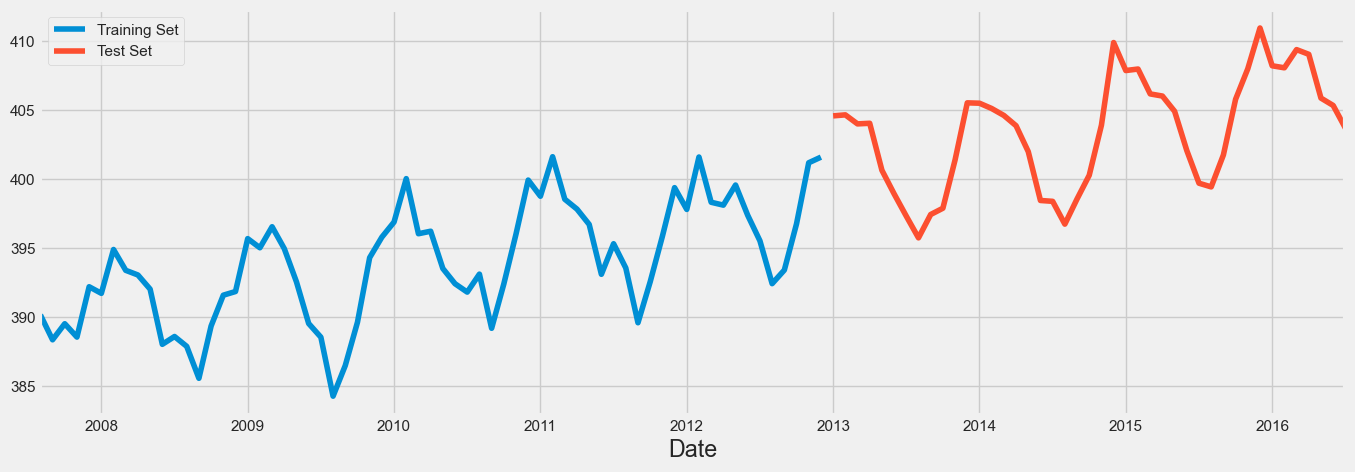

In [27]:
train = bou_monthly.loc[bou_monthly.index < '2013-01-01']
test = bou_monthly.loc[bou_monthly.index > '2013-01-01']

fig, ax = plt.subplots(figsize=(15, 5))
train['value'].plot(ax=ax, label='Training Set')
test['value'].plot(ax=ax, label='Test Set')

plt.legend()
plt.show();

In [28]:
def create_features(df):
    df = df.copy()
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['season'] = ((df.index.month % 12 + 3) // 3)
    return df

In [29]:
train = create_features(train)
test = create_features(test)

In [30]:
features = ['year', 'quarter', 'month', 'season']
target = ['Average Dew Point Temperature',
          'Average Wind Speed',
          'Total Monthly Precipitation',
          'Monthly Average of the daily percents of possible sunshine',
          'Average Monthly Temperature',
          'Monthly Maximum Temperature',
          'Monthly Minimum Temperature',
          'Relative Humidity',
          'value',
          'CO2 value with subtracted rolling mean']

In [31]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [32]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)

reg.fit(X_train, y_train['CO2 value with subtracted rolling mean'],
        eval_set=[(X_train, y_train['CO2 value with subtracted rolling mean']),
                  (X_test, y_test['CO2 value with subtracted rolling mean'])],
        verbose=100)

[0]	validation_0-rmse:0.49431	validation_1-rmse:0.49408
[100]	validation_0-rmse:0.18381	validation_1-rmse:0.18359
[200]	validation_0-rmse:0.06854	validation_1-rmse:0.06833
[300]	validation_0-rmse:0.02602	validation_1-rmse:0.02586
[400]	validation_0-rmse:0.01032	validation_1-rmse:0.01016
[500]	validation_0-rmse:0.00462	validation_1-rmse:0.00465
[600]	validation_0-rmse:0.00258	validation_1-rmse:0.00337
[700]	validation_0-rmse:0.00180	validation_1-rmse:0.00321
[800]	validation_0-rmse:0.00157	validation_1-rmse:0.00315
[900]	validation_0-rmse:0.00152	validation_1-rmse:0.00313
[999]	validation_0-rmse:0.00151	validation_1-rmse:0.00312


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [33]:
reg.feature_importances_

array([0.11694635, 0.45230615, 0.12885807, 0.30188942], dtype=float32)

In [34]:
feat_importance = pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['importance'])

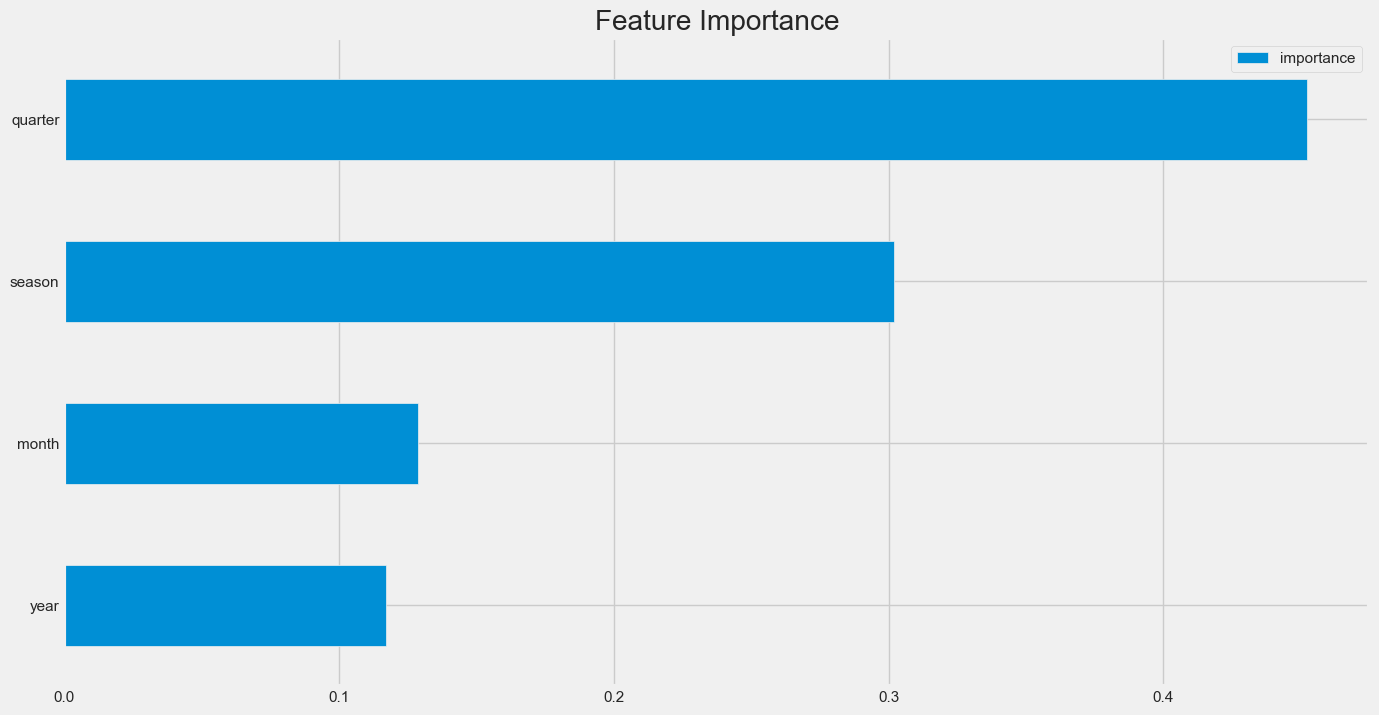

In [35]:
feat_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show();

In [36]:
test['predictions'] = reg.predict(X_test)

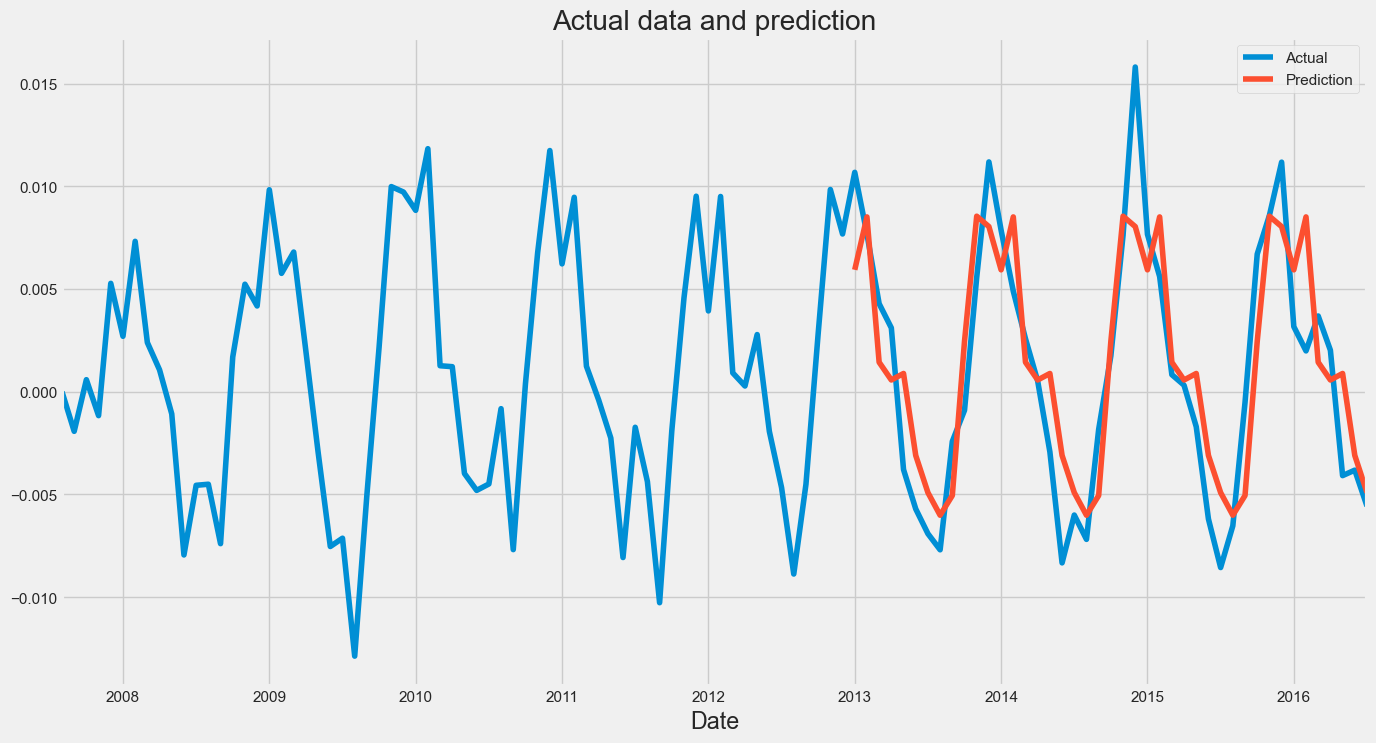

In [37]:
ax = bou_monthly[['CO2 value with subtracted rolling mean']].plot(figsize=(15,8))
test['predictions'].plot(ax=ax)
plt.legend(['Actual', 'Prediction'])
ax.set_title('Actual data and prediction')
plt.show();

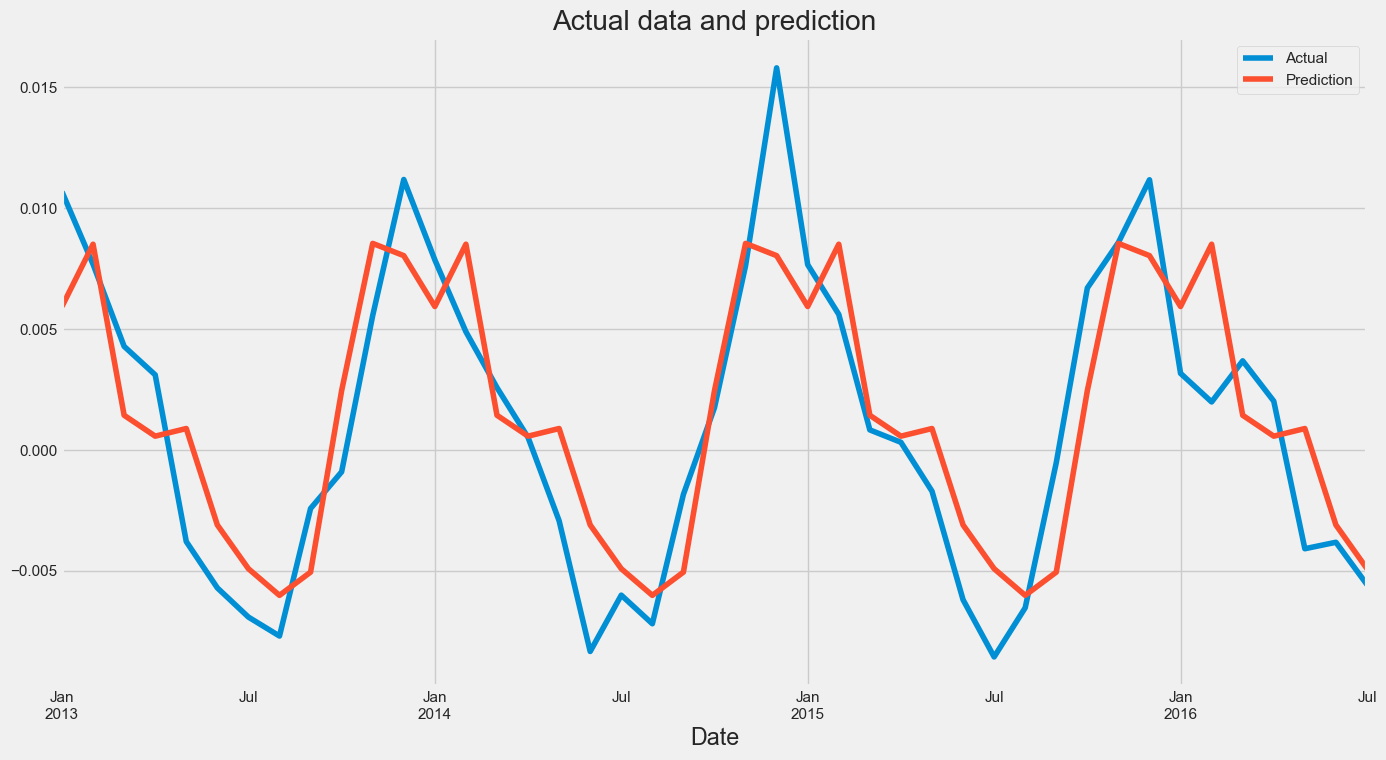

In [38]:
ax = bou_monthly.loc[(bou_monthly.index > '2013-01-01') & (bou_monthly.index < '2023-01-01')]['CO2 value with subtracted rolling mean'].plot(figsize=(15,8))
test['predictions'].plot()
plt.legend(['Actual', 'Prediction'])
ax.set_title('Actual data and prediction')
plt.show();

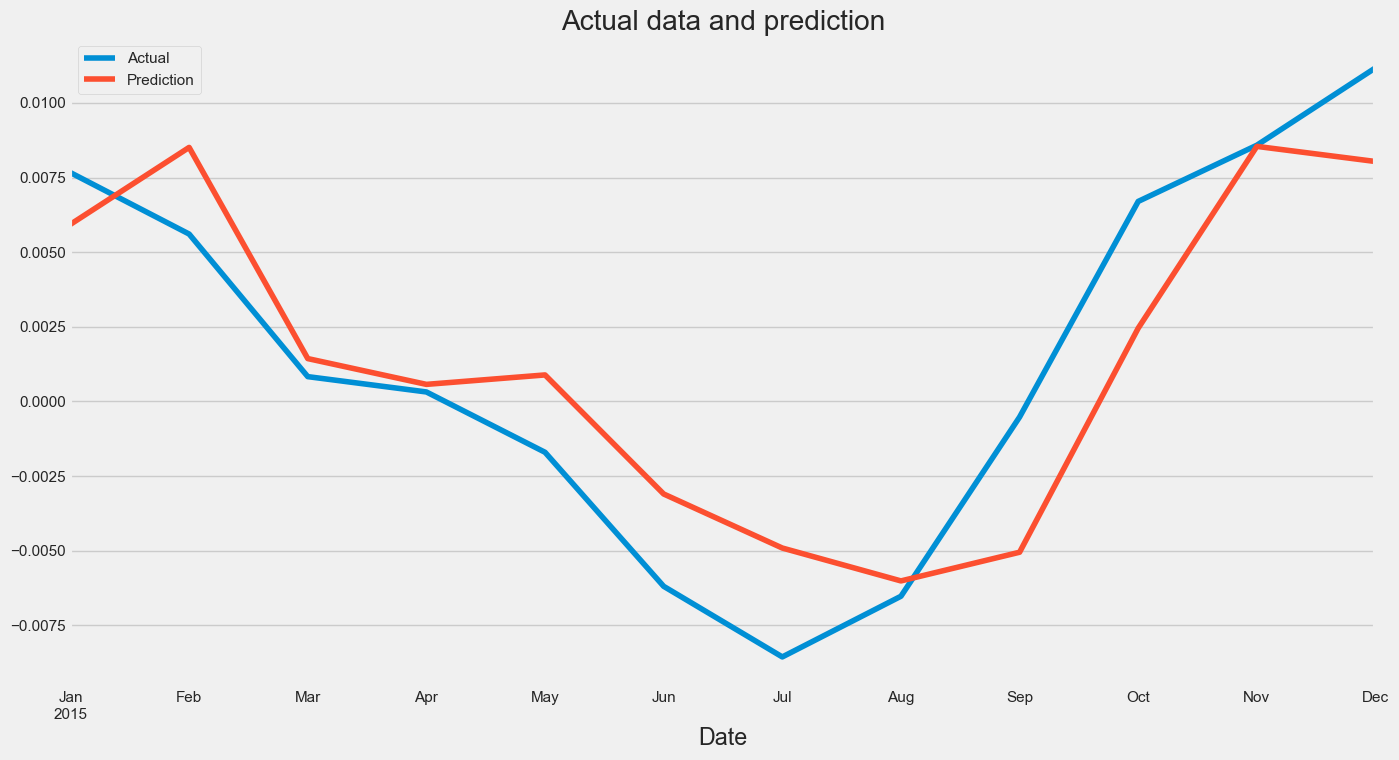

In [39]:
ax = bou_monthly.loc[(bou_monthly.index > '2015-01-01') & (bou_monthly.index < '2016-01-01')]['CO2 value with subtracted rolling mean'].plot(figsize=(15,8))
test.loc[(test.index > '2015-01-01') & (test.index < '2016-01-01')]['predictions'].plot()
plt.legend(['Actual', 'Prediction'])
ax.set_title('Actual data and prediction')
plt.show();

In [40]:
score = np.sqrt(mean_squared_error(test['CO2 value with subtracted rolling mean'], test['predictions']))
print(f'RMSE Score of test set: {score:0.2f}')

RMSE Score of test set: 0.00


In [41]:
test['predictions']

Date
2013-01-31    0.005934
2013-02-28    0.008509
2013-03-31    0.001436
2013-04-30    0.000572
2013-05-31    0.000888
2013-06-30   -0.003099
2013-07-31   -0.004909
2013-08-31   -0.006011
2013-09-30   -0.005050
2013-10-31    0.002455
2013-11-30    0.008544
2013-12-31    0.008037
2014-01-31    0.005934
2014-02-28    0.008509
2014-03-31    0.001436
2014-04-30    0.000572
2014-05-31    0.000888
2014-06-30   -0.003099
2014-07-31   -0.004909
2014-08-31   -0.006011
2014-09-30   -0.005050
2014-10-31    0.002455
2014-11-30    0.008544
2014-12-31    0.008037
2015-01-31    0.005934
2015-02-28    0.008509
2015-03-31    0.001436
2015-04-30    0.000572
2015-05-31    0.000888
2015-06-30   -0.003099
2015-07-31   -0.004909
2015-08-31   -0.006011
2015-09-30   -0.005050
2015-10-31    0.002455
2015-11-30    0.008544
2015-12-31    0.008037
2016-01-31    0.005934
2016-02-29    0.008509
2016-03-31    0.001436
2016-04-30    0.000572
2016-05-31    0.000888
2016-06-30   -0.003099
2016-07-31   -0.004909
Freq: 

In [42]:
test['error'] = np.abs(test['CO2 value with subtracted rolling mean'] - test['predictions'])

In [43]:
test['date'] = test.index.date

In [44]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head()

date
2014-12-31    0.007766
2016-02-29    0.006522
2014-06-30    0.005231
2016-05-31    0.004971
2013-01-31    0.004745
Name: error, dtype: float64

In [45]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head()

date
2015-11-30    0.000039
2014-04-30    0.000052
2015-04-30    0.000254
2015-08-31    0.000514
2015-03-31    0.000604
Name: error, dtype: float64

In [46]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=12, gap=2)

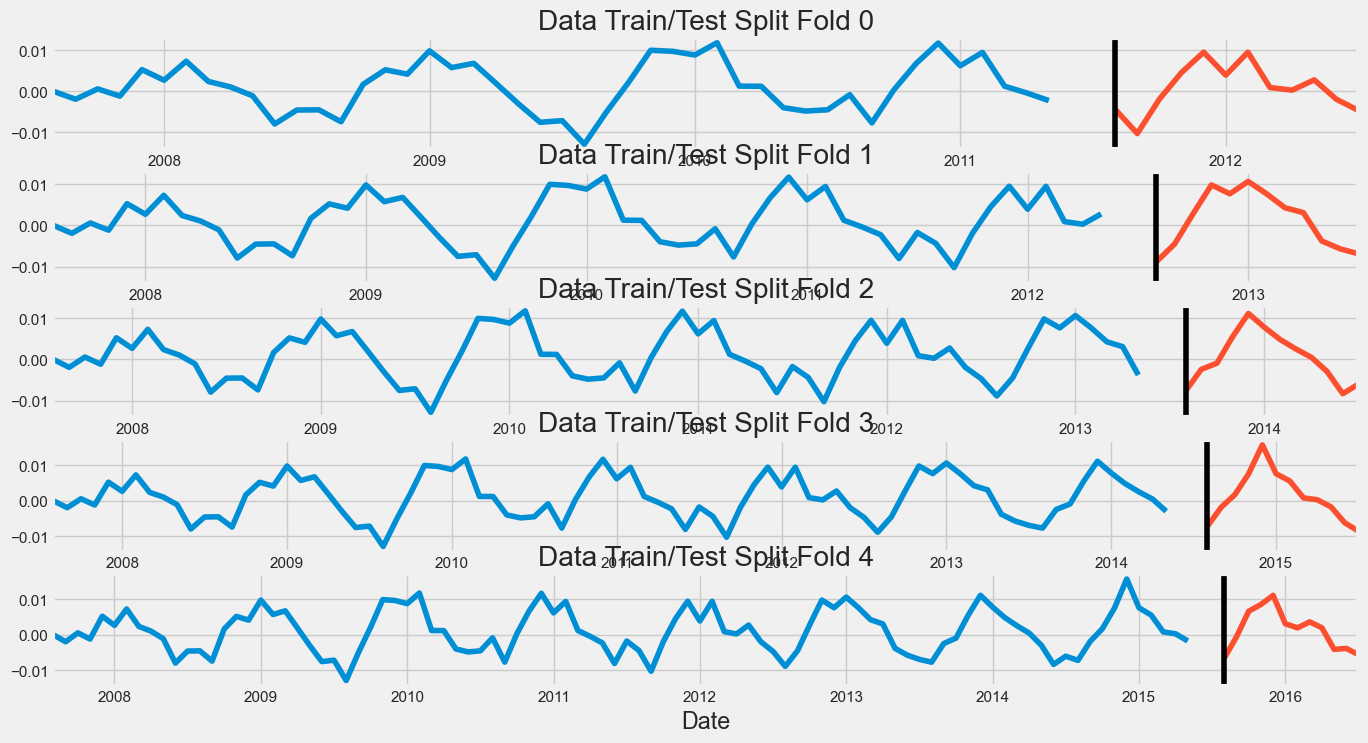

In [47]:
fig, axs = plt.subplots(5, 1, figsize=(15,8))

fold = 0
for train_idx, val_idx in tss.split(bou_monthly):
    train = bou_monthly.iloc[train_idx]
    test = bou_monthly.iloc[val_idx]
    train['CO2 value with subtracted rolling mean'].plot(ax=axs[fold],
                        label='Training Set',
                        title=f'Data Train/Test Split Fold {fold}')
    test['CO2 value with subtracted rolling mean'].plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black')
    fold += 1
plt.show()

In [48]:
target_map = bou_monthly['CO2 value with subtracted rolling mean'].to_dict()

In [49]:
bou_monthly.index - pd.Timedelta('30 days')

DatetimeIndex(['2007-08-01', '2007-08-31', '2007-10-01', '2007-10-31',
               '2007-12-01', '2008-01-01', '2008-01-30', '2008-03-01',
               '2008-03-31', '2008-05-01',
               ...
               '2015-10-01', '2015-10-31', '2015-12-01', '2016-01-01',
               '2016-01-30', '2016-03-01', '2016-03-31', '2016-05-01',
               '2016-05-31', '2016-07-01'],
              dtype='datetime64[ns]', name='Date', length=108, freq=None)

In [50]:
def add_lags(df):
    df['lag 1'] = (df.index - pd.Timedelta('31 days')).map(target_map)
    df['lag 2'] = (df.index - pd.Timedelta('61 days')).map(target_map)
    df['lag 3'] = (df.index - pd.Timedelta('92 days')).map(target_map)
    return df

In [51]:
df = add_lags(bou_monthly)

In [52]:
tss = TimeSeriesSplit(n_splits=5, test_size=12, gap=2)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    features = ['year', 'quarter', 'season', 'month']
    target = 'CO2 value with subtracted rolling mean'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    reg = xgb.XGBRegressor(base_score=0.3, booster='gbtree',
                           n_estimator=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=5,
                           learning_rate=0.1)
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train),
                      (X_test, y_test)],
            verbose=20)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[20:34:44] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:34:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[0]	validation_0-rmse:0.26978	validation_1-rmse:0.27010
[20]	validation_0-rmse:0.03488	validation_1-rmse:0.03515
[40]	validation_0-rmse:0.00551	validation_1-rmse:0.00571
[60]	validation_0-rmse:0.00188	validation_1-rmse:0.00301
[80]	validation_0-rmse:0.00155	validation_1-rmse:0.00271
[99]	validation_0-rmse:0.00154	validation_1-rmse:0.00269
[20:34:44] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:34:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[0]	validation_0-rm

In [53]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Folds scores:{scores}')

Score across folds 0.0030
Folds scores:[0.0026930018854852003, 0.00434358521261703, 0.0024845712345406543, 0.0025099835918631005, 0.002827154039342417]


### Average Monthly Temperature Prediction

In [54]:
def exp_rolling_mean(df, target='value'):
    # a sqrt transformation is used due to the presence of zero values
    data = pd.Series(np.sqrt(df[target]), index=df.index)
    exp_roll_mean = data.ewm(halflife=2).mean()
    data_minus_exp_roll_mean = data - exp_roll_mean
    return data_minus_exp_roll_mean

In [55]:
for df in list_df:
    df[['Average Dew Point Temperature',
        'Average Monthly Temperature',
        'Monthly Maximum Temperature',
        'Monthly Minimum Temperature']] += 273

In [56]:
bou_monthly['Rolling mean of average temperature'] = exp_rolling_mean(bou_monthly,
                                                                      target='Average Monthly Temperature')

In [57]:
def train_test_split(df, split_date):
    df = df.copy()
    return df.loc[df.index < split_date], df.loc[df.index >= split_date]

In [58]:
def split_date(df):
    return df.index[int(len(df.index)*.75)]

In [59]:
def create_features(df):
    df = df.copy()
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['season'] = ((df.index.month % 12 + 3) // 3)
    return df

In [60]:
target = ['Average Dew Point Temperature',
          'Average Wind Speed',
          'Total Monthly Precipitation',
          'Monthly Average of the daily percents of possible sunshine',
          'Average Monthly Temperature',
          'Monthly Maximum Temperature',
          'Monthly Minimum Temperature',
          'Relative Humidity',
          'value']

def XGBoost_model(df, variable):
    train, test = train_test_split(df,
                                   split_date(df[variable]))

    train = create_features(train)
    test = create_features(test)

    X_train = train[features]
    y_train = train[target]

    X_test = test[features]
    y_test = test[target]

    reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)

    reg.fit(X_train, y_train[variable],
            eval_set=[(X_train, y_train[variable]),
                      (X_test, y_test[variable])],
            verbose=100)
    feat_importance = pd.DataFrame(data=reg.feature_importances_,
                index=reg.feature_names_in_,
                columns=['importance'])

    feat_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
    plt.show();
    
    test['predictions'] = reg.predict(X_test)
    return test

[0]	validation_0-rmse:280.46719	validation_1-rmse:281.88185
[100]	validation_0-rmse:104.20227	validation_1-rmse:105.59464
[200]	validation_0-rmse:39.23646	validation_1-rmse:40.43125
[300]	validation_0-rmse:15.10352	validation_1-rmse:15.82979
[400]	validation_0-rmse:6.02230	validation_1-rmse:6.39957
[500]	validation_0-rmse:2.71362	validation_1-rmse:2.97110
[600]	validation_0-rmse:1.38784	validation_1-rmse:2.04457
[700]	validation_0-rmse:0.81792	validation_1-rmse:1.85617
[769]	validation_0-rmse:0.60763	validation_1-rmse:1.86029


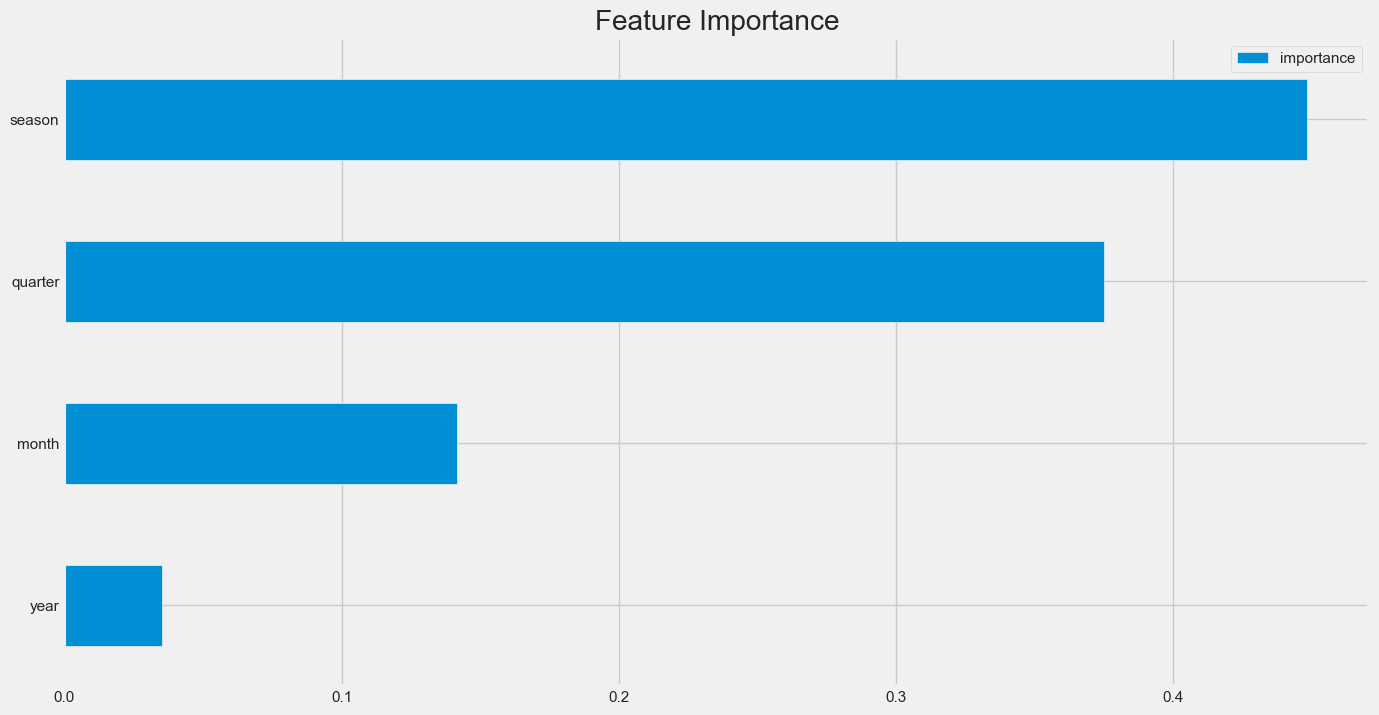

In [61]:
test_bou = XGBoost_model(bou_monthly, 'Average Monthly Temperature')

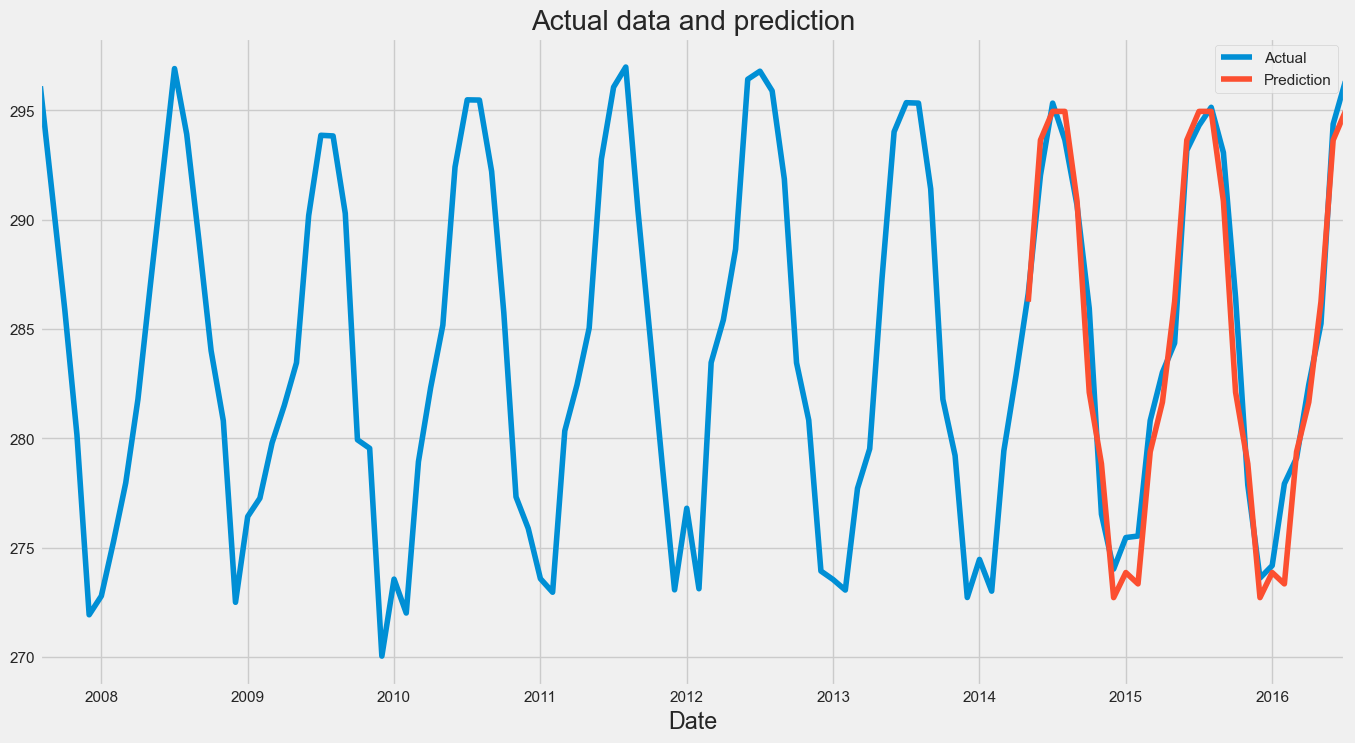

In [62]:
ax = bou_monthly['Average Monthly Temperature'].plot(figsize=(15,8))
test_bou['predictions'].plot(ax=ax)
plt.legend(['Actual', 'Prediction'])
ax.set_title('Actual data and prediction')
plt.show();

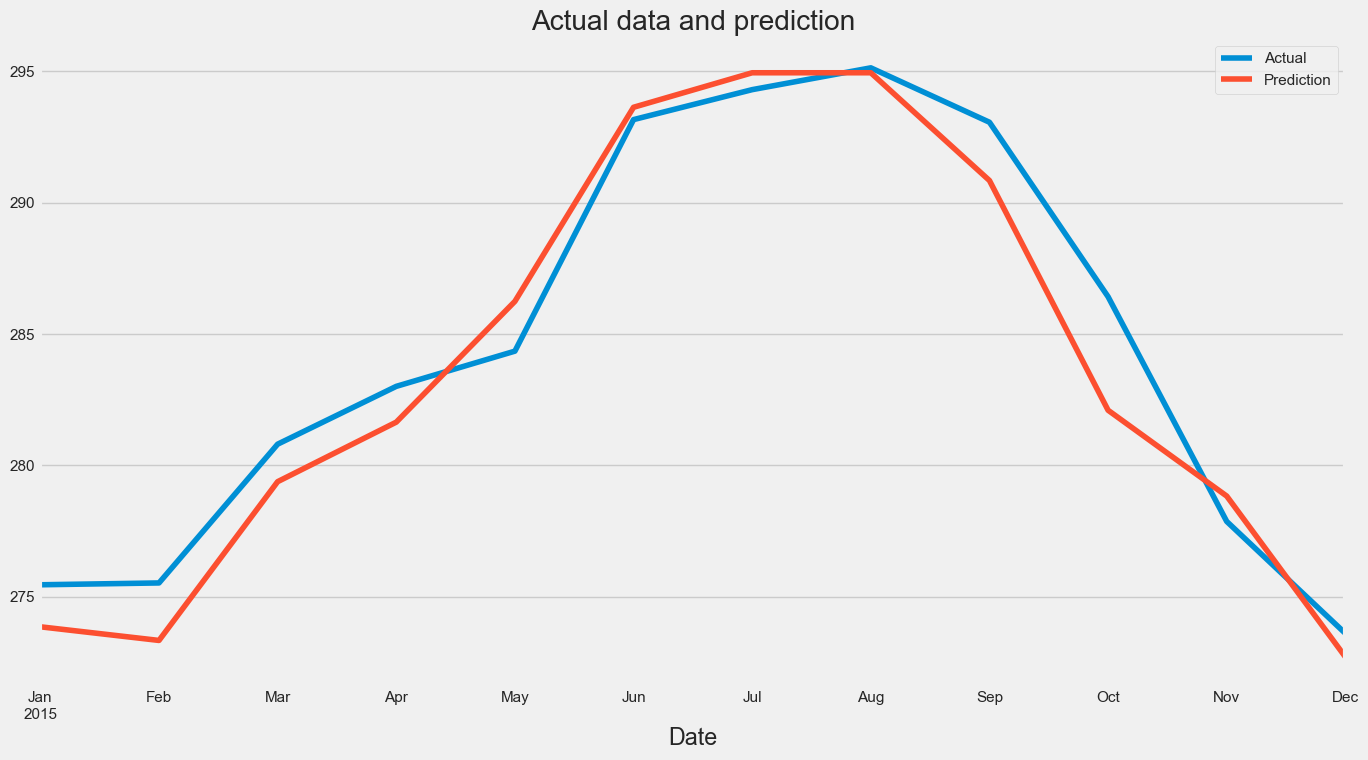

In [63]:
ax = bou_monthly.loc[(bou_monthly.index > '2015-01-01') & (bou_monthly.index < '2016-01-01')]['Average Monthly Temperature'].plot(figsize=(15,8))
test_bou.loc[(test_bou.index > '2015-01-01') & (test_bou.index < '2016-01-01')]['predictions'].plot()
plt.legend(['Actual', 'Prediction'])
ax.set_title('Actual data and prediction')
plt.show();

In [64]:
score = np.sqrt(mean_squared_error(test_bou['Average Monthly Temperature'], test_bou['predictions']))
print(f'RMSE Score of test set: {score:0.2f}')

RMSE Score of test set: 1.85


In [65]:
test_bou['error'] = np.abs(test_bou['Average Monthly Temperature'] - test_bou['predictions'])
test_bou['date'] = test_bou.index.date
test_bou.groupby('date')['error'].mean().sort_values(ascending=False).head()

date
2016-02-29    4.577806
2015-10-31    4.319170
2014-10-31    3.839170
2014-11-30    2.305114
2015-09-30    2.217532
Name: error, dtype: float64

In [66]:
test_bou.groupby('date')['error'].mean().sort_values(ascending=True).head()

date
2015-08-31    0.187526
2014-09-30    0.192468
2016-03-31    0.283362
2016-01-31    0.318916
2014-05-31    0.375676
Name: error, dtype: float64